# Weighting query terms to improve BM25 retrieval

In [1]:
import csv
import matplotlib.pyplot as plt
from src.retrieval import PyLuceneRetriever, ReCodeRetriever, OracleBLEURetriever
import tqdm.notebook as tqdm 
from hyperopt import hp, fmin, tpe, space_eval
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [2]:
# takes a few seconds
collection = {}
with open('datasets/MS_Marco/collection.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for i, row in enumerate(reader):
        passage_id, passage_text = row
        collection[int(passage_id)] = passage_text

In [3]:
train_queries = {}
with open('datasets/MS_Marco/queries.train.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for i, row in enumerate(reader):
        q_id, q_text = row
        train_queries[int(q_id)] = q_text

In [4]:
train_q_rels = {}
with open('datasets/MS_Marco/qrels.train.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for i, row in enumerate(reader):
        q_id, _, passage_id, _ = row
        if int(q_id) in train_q_rels:
            train_q_rels[int(q_id)].append(int(passage_id))
        else:
            train_q_rels[int(q_id)] = [int(passage_id)]

(array([4.7758e+05, 2.1868e+04, 0.0000e+00, 2.7180e+03, 0.0000e+00,
        6.1200e+02, 1.3100e+02, 0.0000e+00, 2.2000e+01, 8.0000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 10 Patch objects>)

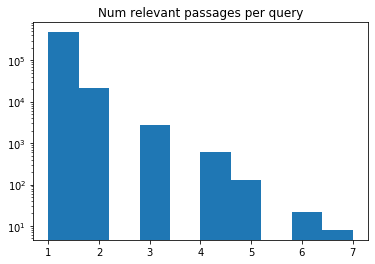

In [5]:
plt.title('Num relevant passages per query')
plt.hist([len(rel_passages) for q_id, rel_passages in train_q_rels.items()],log=True)

## Importing passages into PyLucene

In [6]:
ordered_passages = [v for k, v in sorted(collection.items(), key=lambda item: item[0])]

In [7]:
print(f"All passages {len(ordered_passages)}")

All passages 8841823


In [69]:
%%time
retriever = PyLuceneRetriever()
retriever.add_multiple_docs(ordered_passages[:10_000])

JVM Running
CPU times: user 290 ms, sys: 11 ms, total: 301 ms
Wall time: 299 ms


In [70]:
retriever.store

<RAMDirectory: RAMDirectory@5f0c0573 lockFactory=org.apache.lucene.store.SingleInstanceLockFactory@2018c2c5>

In [71]:
k = 3
results = retriever.search("french pastries", max_retrieved_docs=100)
print(f"{len(results)} results")
top_k_passages = [ordered_passages[passage_id] for passage_id, sccore in results[:k]]
for p in top_k_passages:
    print(p)
    print()

french pastries foo
65 results
Locations farthest away from Salt Lake City. 1  Amsterdam Island, French Southern Territories, 11,894 mi. 2  Port-aux-Francais, French Southern Territories, 11,829 mi. 3  Ãle de la Possession, Crozet Islands, French Southern Territories, 11,532 mi.  Port Mathurin (Rodrigues), Mauritius, 10,952 1  mi. Saint-Pierre, RÃ©union (French), 10,903  mi.

Meaning of Eleanor. French name. In French, the name Eleanor means - A variant of Helen introduced into Britain in 12th century AD by King Henry IIs wife, Eleanor of Aquitaine.. Other origins for the name Eleanor include - French, Greek, English.The name Eleanor is most often used as a girl name or female name. French Name Meaning - A variant of Helen introduced into Britain in 12th century AD by King Henry IIs wife, Eleanor of Aquitaine. Origin - French.

Origin of Goins, Meaning of Goins. Origin: The name is french meaning GOD's friend. Has many variations to the name, Goin, Goings, Gains, Goines. All derived f

# Creating the experimental setup

In [7]:
from src.dataset_loaders import MS_Marco_RawDataLoader

In [8]:
marco_raw_dataloader = MS_Marco_RawDataLoader()

In [9]:
from src.Experiments import Experiment
import numpy as np

In [10]:
class IR_Experiment(Experiment):
    def __init__(self, doc_collection, query_collection, q_rels, at=1000):
        """
        doc_collection: {doc_id:str}: document collection
        query_collection: {q_id:str}: query collection 
        q_rels: {q_id:[doc_id,...]}: link from a split between the doc_colllection and the query_collection
        """
        self.doc_collection = doc_collection
        self.query_collection = query_collection
        self.q_rels = q_rels
        self.at = at
    
    def evaluate(self, prediction_fn):
        """
        This function should compute all relevant metrics to the task,
        prediction_fn: (q_id, doc_collection, query_collection) -> ([doc_id,...]): input is the query and the output is a 
                                                                                predicted ordered list for document relevance
        returns: dict: metrics
        """
        results = {'NDCG':[]}
        for q_id, relevant_docs in tqdm.tqdm(self.q_rels.items()):
            pred_relevant_docs = prediction_fn(q_id, self.doc_collection, self.query_collection)[:self.at]
            NDCG = self.calc_NDCG(pred_relevant_docs, relevant_docs)
            results["NDCG"].append(NDCG)
        results["NDCG"] = np.average(results["NDCG"])
        return results
    
    def calc_NDCG(self, pred_relevant_docs, relevant_docs):
        DCG = 0
        for i, pred_doc_id in enumerate(pred_relevant_docs):
            if pred_doc_id in relevant_docs:
                DCG += 1/np.log2(2+i)
        IDCG = sum(1/np.log(np.arange(1, len(relevant_docs)+1)+1))
        return DCG/IDCG
    
    
    def single_eval(self, prediction_fn, q_id=None):
        q_id = q_id if q_id else sorted(list(self.q_rels.keys()))[0]
        assert q_id in self.q_rels, f"q_id: {q_id} not found!"
        pred_relevant_docs = prediction_fn(q_id, self.doc_collection, self.query_collection)[:self.at]
        relevant_docs = self.q_rels[q_id]
        NDCG = self.calc_NDCG(pred_relevant_docs, relevant_docs)
        return NDCG

In [11]:
collection = marco_raw_dataloader.collection
queries = marco_raw_dataloader.queries
dev_qrels = marco_raw_dataloader.q_rels("dev")
small_dev_qrels = {k:v for k, v in list(dev_qrels.items()) if all(i < 100_000 for i in v)}

IR_exp = IR_Experiment(collection, queries, small_dev_qrels)

In [12]:
list(small_dev_qrels.keys())[11:30]

[1063674,
 1045185,
 1044632,
 1036748,
 1033126,
 1029622,
 1027373,
 1020842,
 1019783,
 1012331,
 1006287,
 993871,
 1099098,
 988605,
 988044,
 985348,
 985259,
 281388,
 316195]

In [14]:
def dummy_ranker(q_id, doc_collection, query_collection):
    return np.random.randint(3000, size=100)

In [15]:
IR_exp.evaluate(dummy_ranker)

{'NDCG': 0.0}

In [13]:
class BM25_Ranker():
    def __init__(self, doc_collection, index_path = None, max_docs=None):
        ordered_passages = [v for k, v in sorted(doc_collection.items(), key=lambda item: item[0])]
        self.retriever = PyLuceneRetriever(index_path)
        self.retriever.add_multiple_docs(ordered_passages[:max_docs])
        
    def __call__(self, q_id, _, query_collection):
        results = self.retriever.search(query_collection[q_id], max_retrieved_docs=1000)
        return [passage_id for passage_id, sccore in results]

bm25_ranker = BM25_Ranker(collection, index_path="/tmp/bm25", max_docs=100_000)

In [14]:
IR_exp.evaluate(bm25_ranker)

{'NDCG': 0.2950855867262168}

In [147]:
bm25_ranker(760804, None, queries)[:10]

[58039, 6654, 53499, 53496, 6660, 46966, 58037, 97447, 85237, 58041]

In [144]:
small_dev_qrels[760804]

[6660, 6654]

In [210]:
queries[760803]

'what is irrigation runoff'

In [182]:
IR_exp.calc_NDCG(bm25_ranker(760804, None, queries)[:10], small_dev_qrels[760804])

0.4325588584676279

In [246]:
%%time
IR_exp.single_eval(bm25_ranker, 261941)

CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 16.4 ms


0.0

# Using Hyperopt to optimise

In [21]:
def best_weights(q_id):
    print(f"Testing: {queries[q_id]}")
    query = queries[q_id].split(" ")
#     space = tuple([hp.uniform(str(i), 1, 10) for i in range(len(query))])
    space = tuple([hp.randint(str(i), 10) for i in range(len(query))])
    
    def NDCG_weight_objective(weights):
        weighted_q = " ".join([f'{word}^{weight}' for word, weight in zip(query, weights)])
        results = bm25_ranker.retriever.search(weighted_q, max_retrieved_docs=10000, k1=3.44, b=0.87)
        preds = [passage_id for passage_id, sccore in results]
        NDCG = IR_exp.calc_NDCG(preds, small_dev_qrels[q_id])
        return -NDCG
    
    def BM25_weight_objective(weights):
        weighted_q = " ".join([f'{word}^{weight}' for word, weight in zip(query, weights)])
        results = bm25_ranker.retriever.search(weighted_q, max_retrieved_docs=10000)
        passage_ids = [passage_id for passage_id, score in results]
        try:
            last_index = max([passage_ids.index(doc_id) for doc_id in small_dev_qrels[q_id] if doc_id in passage_ids]) 
        except:
            last_index = -1
        BM25_score = [score if passage_id in small_dev_qrels[q_id] else -score/len(results[:last_index]) for passage_id, score in results[:last_index]]
        return sum(BM25_score)
    
    best = fmin(BM25_weight_objective, space, algo=tpe.suggest, max_evals=200)
    ordered_weights = [t[1] for t in sorted(best.items(), key=lambda x: int(x[0]))]
    best_weighted_q = " ".join([f'{word}^{weight:.1f}' for word, weight in zip(query, ordered_weights)])
    og_score = NDCG_weight_objective([1]*len(query))
    new_score = NDCG_weight_objective(ordered_weights)
    print("Original score:", NDCG_weight_objective([1]*len(query)), ", new score:", NDCG_weight_objective(ordered_weights))
    return ordered_weights, best_weighted_q, new_score, og_score
    
best_weights(316195)

Testing: how much does it cost to own a horse ranch per year
100%|██████████| 200/200 [00:09<00:00, 21.67trial/s, best loss: -86.58539962768555]
Original score: -0.1554339745143924 , new score: -0.2681459326263225


([1, 7, 5, 9, 9, 4, 0, 7, 9, 0, 7, 5],
 'how^1.0 much^7.0 does^5.0 it^9.0 cost^9.0 to^4.0 own^0.0 a^7.0 horse^9.0 ranch^0.0 per^7.0 year^5.0',
 -0.2681459326263225,
 -0.1554339745143924)

In [ ]:
'how^0 much^1 does^1 it^2 cost^2 to^3 own^3 a^4 horse^6 ranch^0 per^9 year^0',
'how^0 much^1 does^1 it^2 cost^2 to^3 own^3 a^4 horse^6 ranch^0 per^9 year^0',
'how^3 much^9 does^2 it^4 cost^9 to^8 own^3 a^5 horse^9 ranch^0 per^9 year^1',
'how^8 much^0 does^0 it^8 cost^9 to^9 own^0 a^8 horse^9 ranch^9 per^9 year^9'

In [36]:
bm25_ranker.retriever.search('how^0 much^1 does^1 it^2 cost^2 to^3 own^3 a^4 horse^6 ranch^0 per^9 year^0', max_retrieved_docs=15)

[(98297, 47.76103591918945),
 (3742, 46.94272994995117),
 (98298, 46.936119079589844),
 (98295, 46.589046478271484),
 (98301, 46.36630630493164),
 (96573, 46.0514030456543),
 (98300, 45.48631286621094),
 (3743, 43.65251922607422),
 (3740, 43.40089797973633),
 (10896, 40.31120681762695),
 (98294, 39.940582275390625),
 (78075, 39.068275451660156),
 (3741, 38.7597770690918),
 (80178, 34.96807861328125),
 (12462, 33.975624084472656)]

In [35]:
bm25_ranker.retriever.search('how much does it cost to own a horse ranch per year', max_retrieved_docs=20)

[(98294, 12.363020896911621),
 (17181, 11.739583969116211),
 (86281, 11.581016540527344),
 (17184, 11.38760757446289),
 (75587, 11.209770202636719),
 (92637, 11.196121215820312),
 (17178, 11.137279510498047),
 (99671, 10.87394905090332),
 (99667, 10.51490592956543),
 (29336, 10.417116165161133),
 (40564, 10.37366771697998),
 (98298, 10.327714920043945),
 (84810, 10.102272033691406),
 (98300, 9.94822883605957),
 (91561, 9.874801635742188),
 (40559, 9.85165023803711),
 (26342, 9.714899063110352),
 (96573, 9.70451545715332),
 (78078, 9.679361343383789),
 (39935, 9.571218490600586)]

In [34]:
q_id = 316195
print(small_dev_qrels[q_id])
print(queries[q_id])

[98297]
how much does it cost to own a horse ranch per year


In [19]:
# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

100%|██████████| 100/100 [00:00<00:00, 365.71trial/s, best loss: 9.455269061822387e-07]
{'a': 1, 'c2': -0.0009723820782913672}
('case 2', -0.0009723820782913672)
